In [4]:
# import pyBigWig
import h5py
import numpy as np
import matplotlib.pyplot as plt
# from pyliftover import LiftOver
from tqdm import tqdm
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
# from pybedtools import BedTool
from collections import defaultdict
import pysam
from sklearn.metrics import roc_curve, auc
from scipy.stats import spearmanr, pearsonr
from collections import defaultdict

In [18]:
!wget https://cs282-datasets.s3.us-west-1.amazonaws.com/dataset_14-lmnb1_4-cpg.h5

wget: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libuuid.so.1: no version information available (required by wget)
--2023-11-28 20:58:44--  https://cs282-datasets.s3.us-west-1.amazonaws.com/dataset_14-lmnb1_4-cpg.h5
Resolving cs282-datasets.s3.us-west-1.amazonaws.com (cs282-datasets.s3.us-west-1.amazonaws.com)... 52.219.112.241, 52.219.117.114, 52.219.120.209, ...
Connecting to cs282-datasets.s3.us-west-1.amazonaws.com (cs282-datasets.s3.us-west-1.amazonaws.com)|52.219.112.241|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-11-28 20:58:44 ERROR 403: Forbidden.



In [5]:
sequences_bed_path = 'sequences.bed'
# shah_prefix = '/clusterfs/nilah/oberon/datasets/lamina_association_shah/'
# hek_dimelo_prefix = '/clusterfs/nilah/oberon/datasets/cs282a/hek293/'
# gm_dimelo_prefix = '/clusterfs/nilah/oberon/datasets/cs282a/gm12878/'
shah_tracks = ['GSM5669183_CardiacMyocytes_rep1_LB1.bigwig',
               'GSM5669188_APS_rep1_LB1.bigwig',
               'GSM5669193_BorderEctoderm_rep1_LB1.bigwig',
               'GSM5669198_D5Midbrain_rep1_LB1.bigwig',
               'GSM5669203_DefEctoderm_rep1_LB1.bigwig',
               'GSM5669209_EarlySomite_rep1_LB1.bigwig',
               'GSM5669214_EndoProgenitor_rep1_LB1.bigwig',
               'GSM5669220_Epicardium_rep1_LB1.bigwig',
               'GSM5669226_H9ESC_rep1_LB1.bigwig',
               'GSM5669232_Liver_rep1_LB1.bigwig',
               'GSM5669238_MidHindgut_rep1_LB1.bigwig',
               'GSM5669244_ParaxMesoderm_rep1_LB1.bigwig']
dimelo_tracks = ['HEK293_LMNB1','GM12878_LMNB1','HEK293_CpG_methylation','HEK293_CpG_motifs','GM12878_CpG_methylation','GM12878_CpG_motifs']

all_tracks = [shah_track[0:-16] for shah_track in shah_tracks] + dimelo_tracks

dataset_filepath = '/clusterfs/nilah/oberon/datasets/cs282a/dataset_14-lmnb1_4-cpg.h5'

# gtf = BedTool('/clusterfs/nilah/oberon/datasets/gencode/gencode.v44.annotation.gtf')

cm_LAD_tabix_str = 'GSM5669183_CardiacMyocytes_LADs.sorted.bed.gz'
# fl_LAD_tabix_str = '/clusterfs/nilah/oberon/exploratory_data_analysis/lamina_association/GSM5669232_Liver_LADs.sorted.bed.gz'

linear_probe_inference = '/clusterfs/nilah/oberon/datasets/cs282a/inference/probe_first_full_run.h5'
multilayer_inference = 'mlp_model_20231128_063541_2.h5'
maxpool_inference = 'maxpool_model_20231128_072156_3.h5'
transformer_inference = 'transformer_model_20231128_080512_7.h5'

In [6]:
for track_index,track_name in enumerate(all_tracks):
    print(track_name)

GSM5669183_CardiacMyocytes
GSM5669188_APS
GSM5669193_BorderEctoderm
GSM5669198_D5Midbrain
GSM5669203_DefEctoderm
GSM5669209_EarlySomite
GSM5669214_EndoProgenitor
GSM5669220_Epicardium
GSM5669226_H9ESC
GSM5669232_Liver
GSM5669238_MidHindgut
GSM5669244_ParaxMesoderm
HEK293_LMNB1
GM12878_LMNB1
HEK293_CpG_methylation
HEK293_CpG_motifs
GM12878_CpG_methylation
GM12878_CpG_motifs


In [7]:
h5_files_dict = {
    'linear-probe':(linear_probe_inference,'128bp_bins'),
    'conv-perceptron':(multilayer_inference,'single_bin'),
    'maxpool-perceptron':(maxpool_inference,'single_bin'),
    'transformer':(transformer_inference,'single_bin'),
}

In [8]:
chrom_lengths = {    
    'chr1':249000000,
    'chr2':243000000,
    'chr3':198000000,
    'chr4':191000000,
    'chr5':182000000,
    'chr6':171000000,
    'chr7':160000000,
    'chr8':146000000,
    'chr9':140000000,
    'chr10':135000000,
    'chr11':135000000,
}

In [9]:
cm_LADs_tabix = pysam.TabixFile(cm_LAD_tabix_str)
plot_startco = 20000000
plot_endco = 107000000
plot_chrom = 'chr14'
# plot_startco = 0
# plot_endco = 191000000
# plot_chrom = 'chr4'
plot_xcoord = np.arange(start=plot_startco,stop=plot_endco,step=128)
length = len(plot_xcoord)
h5py_files = {}
default_array = np.full((length, 18), np.nan,dtype=float)
def default_factory():
    return default_array.copy()
output_arrays = defaultdict(default_factory)
plot_array_low_res = np.full((length, 18), np.nan)
# plot_array_pred_low_res = np.full((length, 18), np.nan)
plot_array_high_res = np.full((length, 18), np.nan)
# plot_array_pred_high_res = np.full((length, 18), np.nan)
lads_array = np.zeros(length)
test_train_split_array = np.zeros(length)


buffer_at_ends = 8192
seqbedlen = 38171
test_train_split_array
with open(sequences_bed_path,'r') as bed_file, h5py.File(dataset_filepath,'r') as f:
    for key, file_path in h5_files_dict.items():
        h5py_files[key]=h5py.File(file_path[0],'r')
      
    for index,bed_line in tqdm(enumerate(bed_file),total=seqbedlen,desc=f'reading labels and predictions for {plot_chrom}'):
        location_fields = bed_line.split('\t')
        chrom = str(location_fields[0])
        start = int(location_fields[1])+buffer_at_ends
        end = int(location_fields[2])-buffer_at_ends  
        set_int = 0
        if location_fields[3].strip()=='train':
            set_int = 1
        elif location_fields[3].strip()=='valid':
            set_int = 2
        elif location_fields[3].strip()=='test':
            set_int = 3

        lad_type = 0
        for interval in cm_LADs_tabix.fetch(plot_chrom,start,end):
            fields = interval.split('\t')
            lad_type = max(int(fields[3][1]),lad_type)
        
        if end>plot_startco and start<plot_endco and chrom==plot_chrom:
            if start>plot_startco and end<plot_endco:
                for key,file_details in h5_files_dict.items():
#                     print(output_arrays[key][(start-plot_startco)//128:(end-plot_startco)//128,:])
                    output_arrays[key][(start-plot_startco)//128:(end-plot_startco)//128,:] = h5py_files[key][file_details[1]][index,:,:]
#                     print(output_arrays[key][(start-plot_startco)//128:(end-plot_startco)//128,:])
#                 print(plot_array_low_res[(start-plot_startco)//128:(end-plot_startco)//128,:].shape)
                plot_array_low_res[(start-plot_startco)//128:(end-plot_startco)//128,:] = f['single_bin'][index,:,:]
#                 plot_array_pred_low_res[(start-plot_startco)//128:(end-plot_startco)//128,:] = lowres_pred['single_bin'][index,:,:]
                plot_array_high_res[(start-plot_startco)//128:(end-plot_startco)//128,:] = f['128bp_bins'][index,:,:]
#                 plot_array_pred_high_res[(start-plot_startco)//128:(end-plot_startco)//128,:] = highres_pred['128bp_bins'][index,:,:]
                lads_array[(start-plot_startco)//128:(end-plot_startco)//128] = lad_type
                test_train_split_array[(start-plot_startco)//128:(end-plot_startco)//128] = set_int
#             else:
#                 plot_array_low_res[0:(end-plot_startco)//128,:] = f['single_bin'][index,(start-plot_startco)//128:,:]
        

reading labels and predictions for chr14: 100%|██████████| 38171/38171 [00:05<00:00, 7602.83it/s] 


In [10]:
unindexed_num = np.sum(test_train_split_array==0)
train_num = np.sum(test_train_split_array==1)
valid_num = np.sum(test_train_split_array==2)
test_num = np.sum(test_train_split_array==3)
total_num = train_num + valid_num + test_num + unindexed_num
sets_string = f'{100*train_num/total_num:.2f}% training set, {100*valid_num/total_num:.2f}% validation set, {100*test_num/total_num:.2f}% test set, {100*unindexed_num/total_num:.2f}% unindexed'
print(sets_string)

0.00% training set, 0.00% validation set, 98.87% test set, 1.13% unindexed


GSM5669183_CardiacMyocytes	linear-probe	pearson: 0.8534626717397464	spearman: 0.8628373750303578
GSM5669183_CardiacMyocytes	conv-perceptron	pearson: 0.8885724378365866	spearman: 0.8979084084259346
GSM5669183_CardiacMyocytes	maxpool-perceptron	pearson: 0.8742079823093425	spearman: 0.884988750229517
GSM5669183_CardiacMyocytes	transformer	pearson: 0.8862774061077214	spearman: 0.8942725080731725
GSM5669188_APS	linear-probe	pearson: 0.8933582595205968	spearman: 0.9218192826079044
GSM5669188_APS	conv-perceptron	pearson: 0.9585778683089916	spearman: 0.9643291373999838
GSM5669188_APS	maxpool-perceptron	pearson: 0.9244628150564349	spearman: 0.9309052339881465
GSM5669188_APS	transformer	pearson: 0.9604395106558761	spearman: 0.966625936811546
GSM5669193_BorderEctoderm	linear-probe	pearson: 0.7275675523931182	spearman: 0.7128564608394112
GSM5669193_BorderEctoderm	conv-perceptron	pearson: 0.8907368370491482	spearman: 0.8679343087814239
GSM5669193_BorderEctoderm	maxpool-perceptron	pearson: 0.8703696

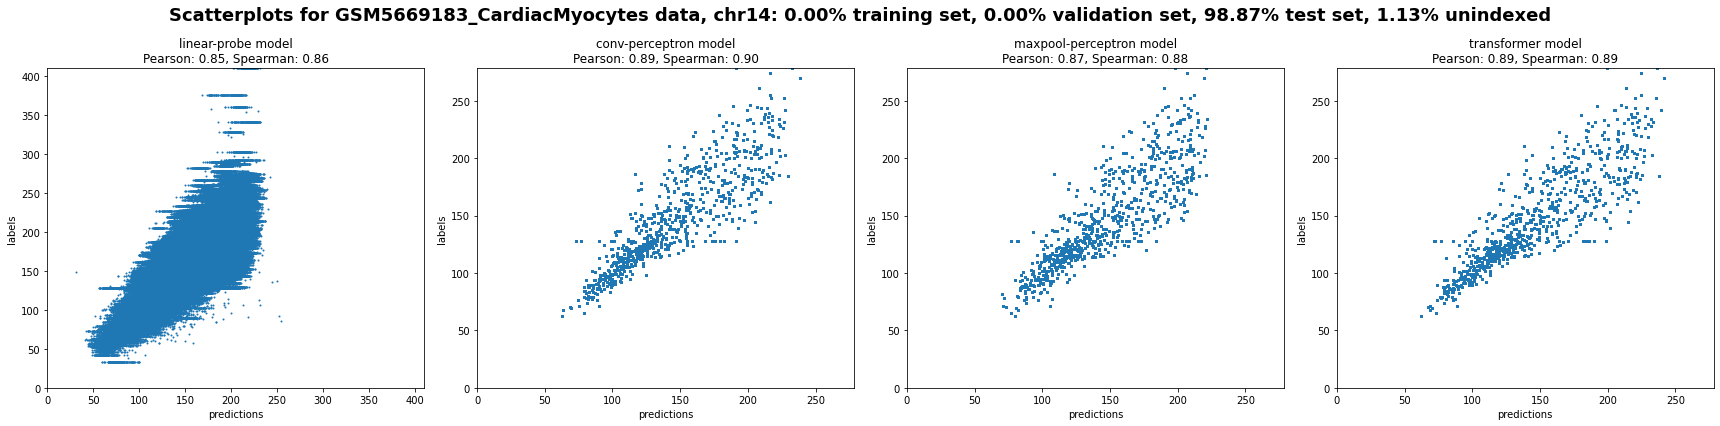

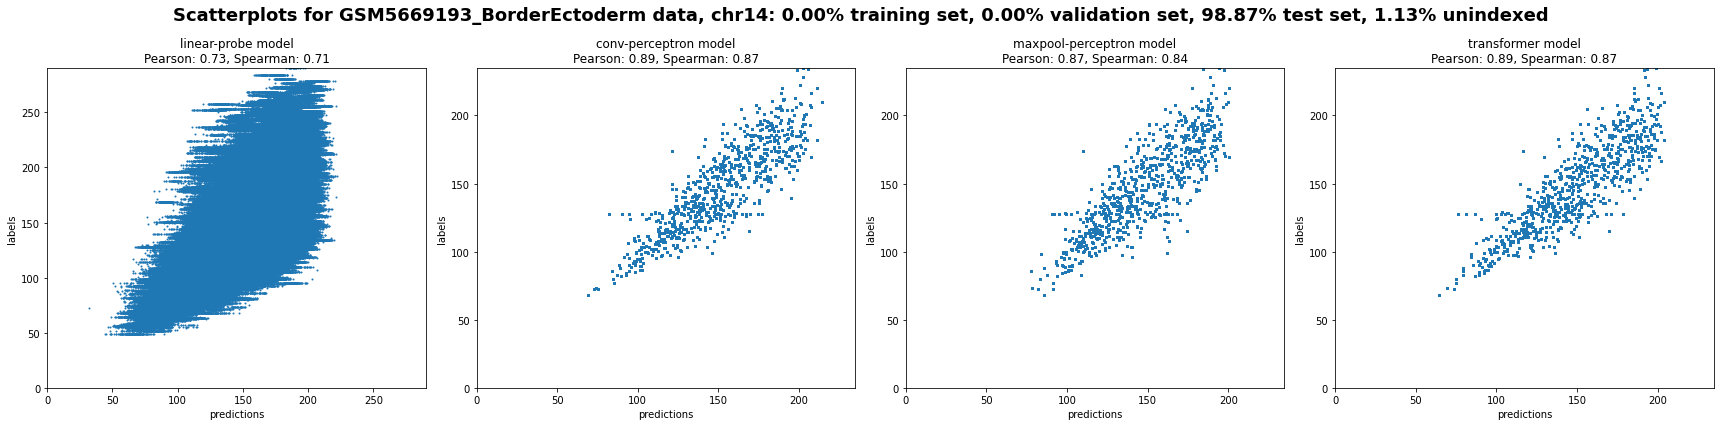

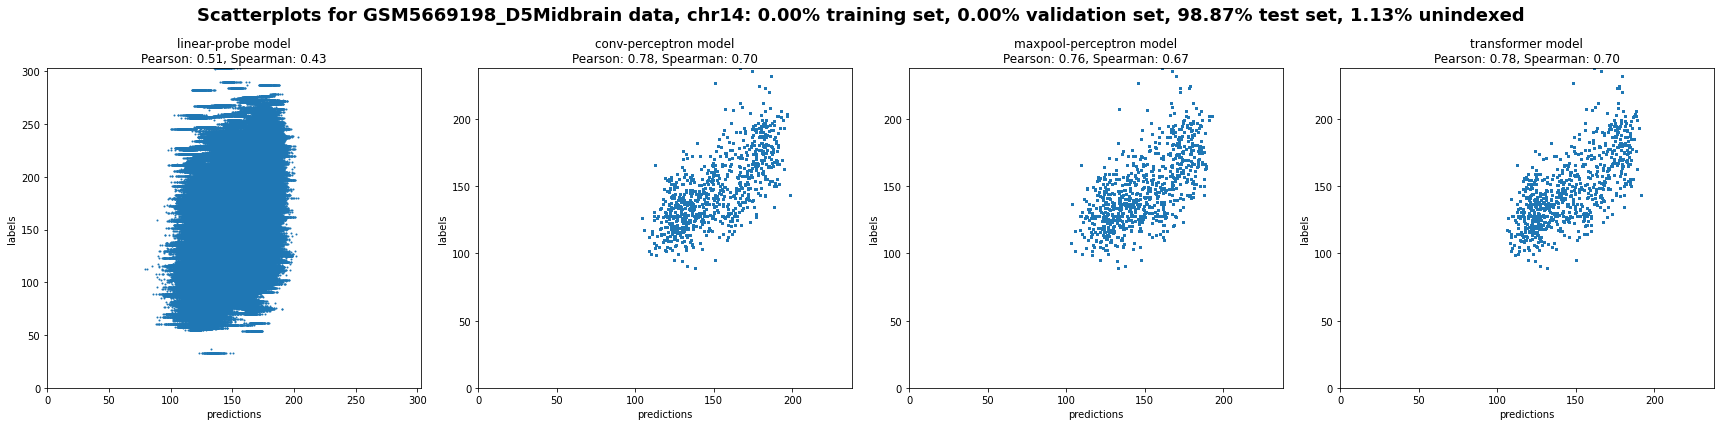

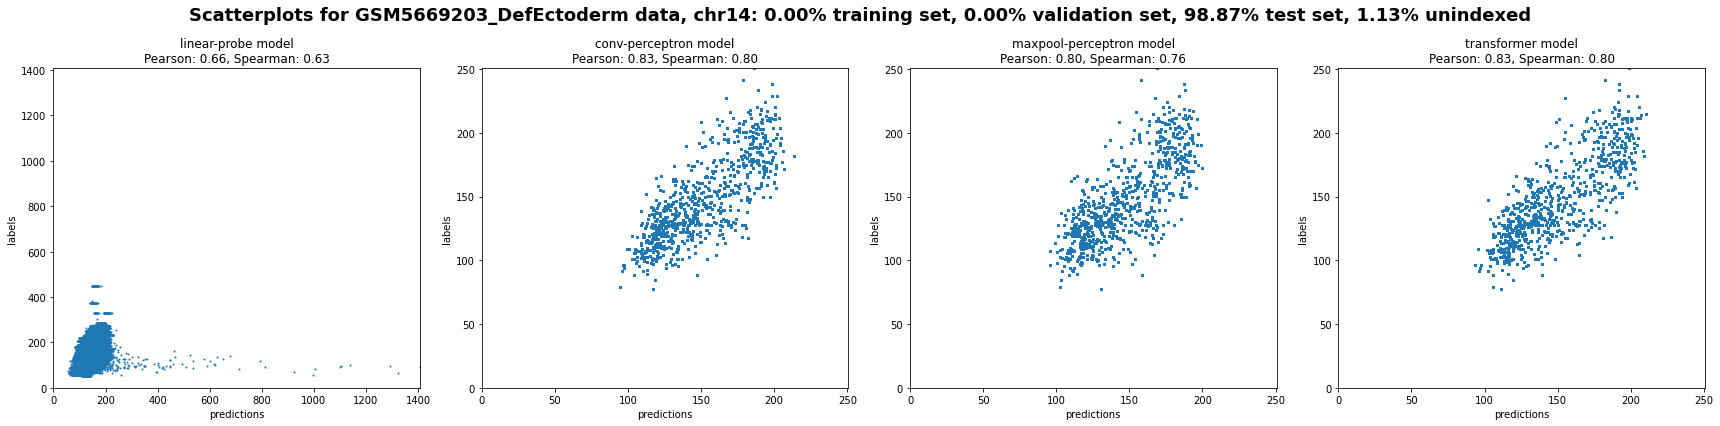

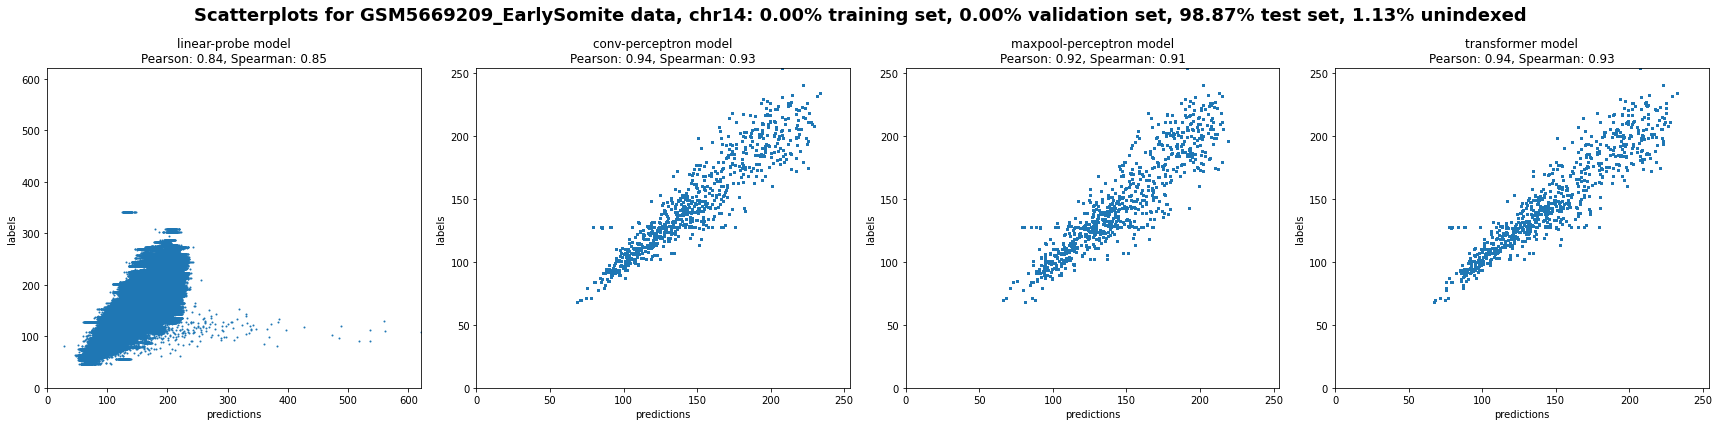

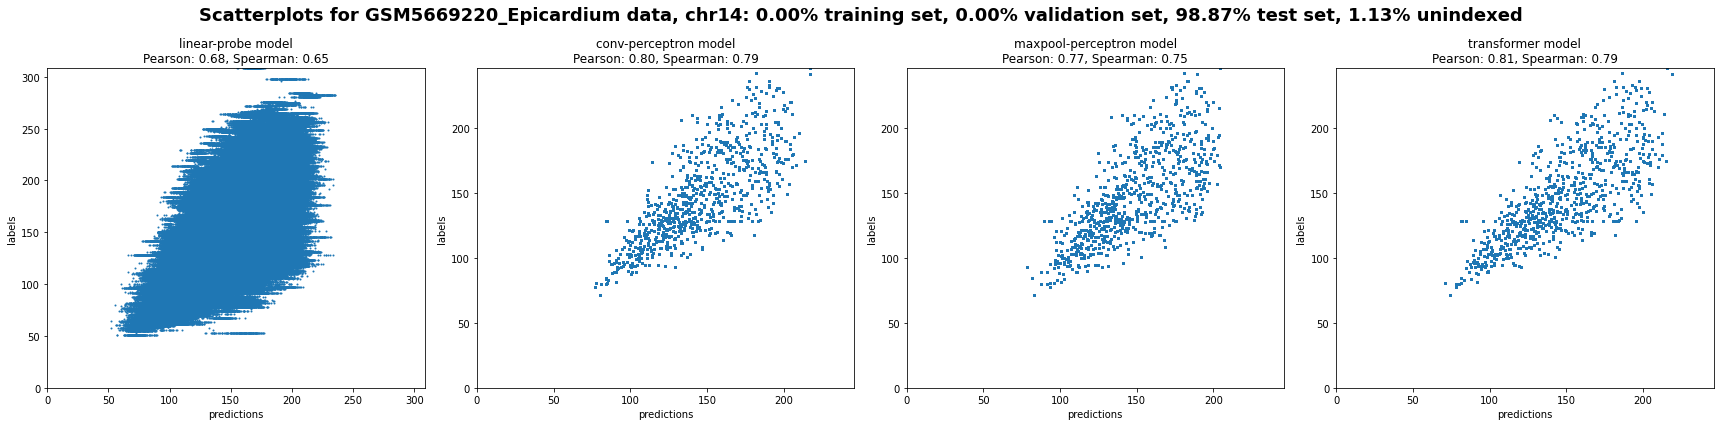

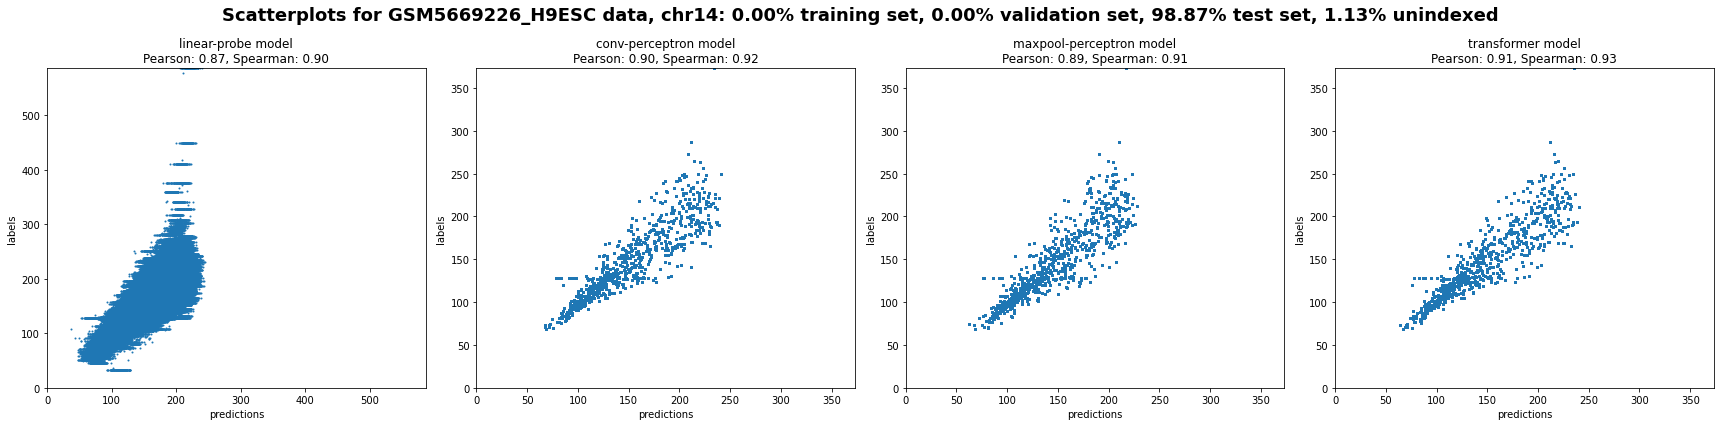

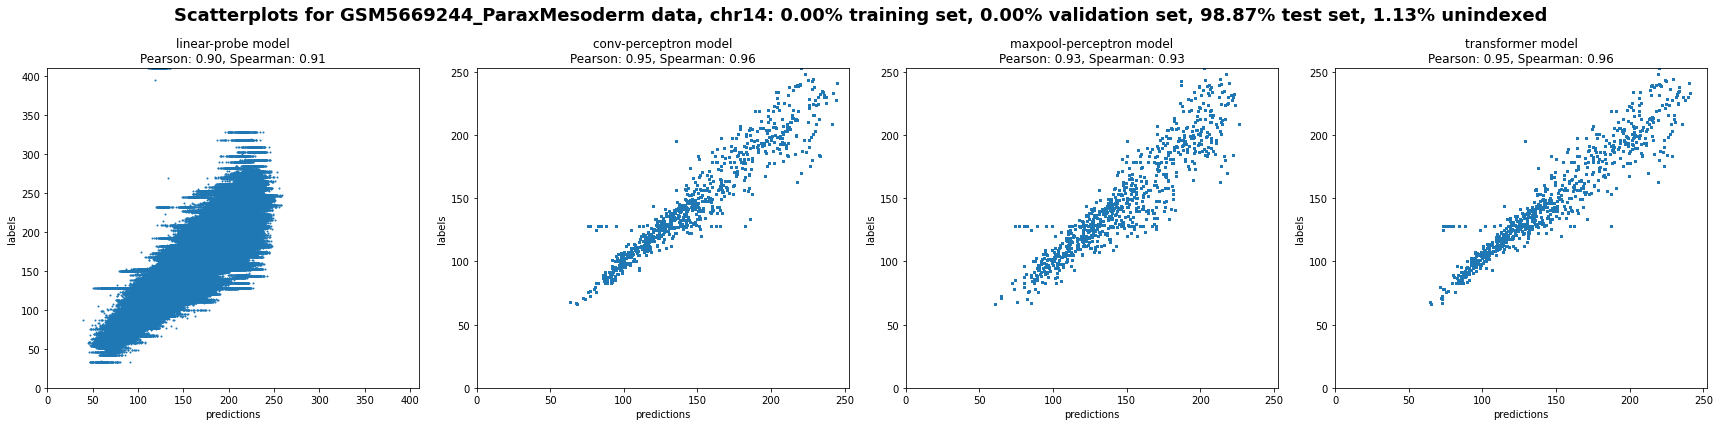

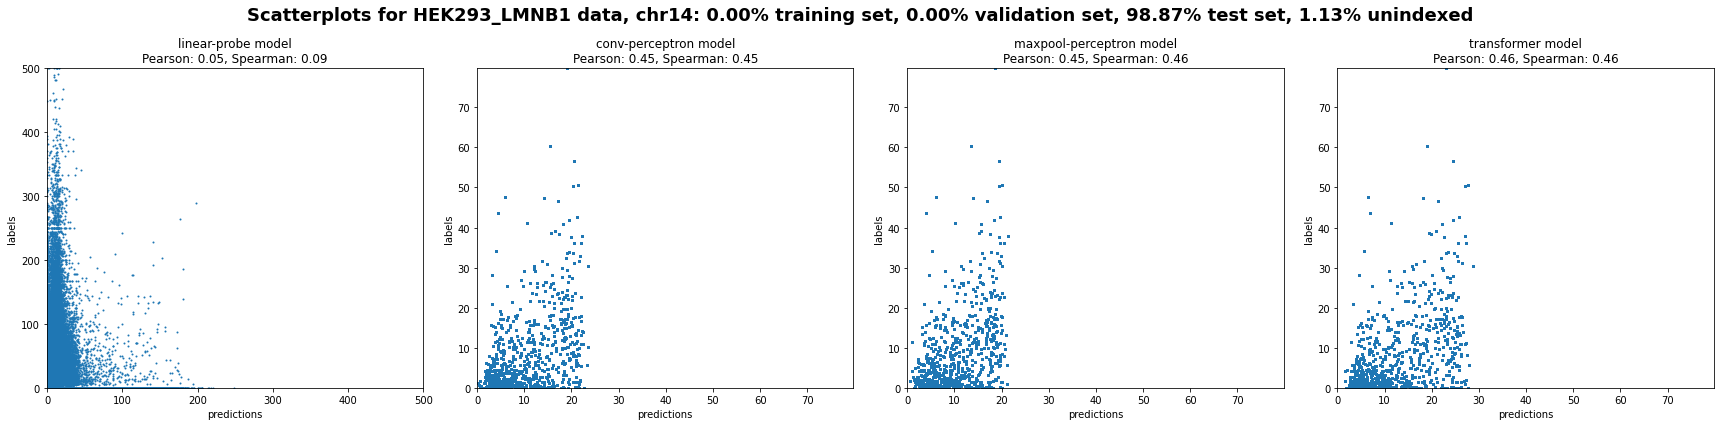

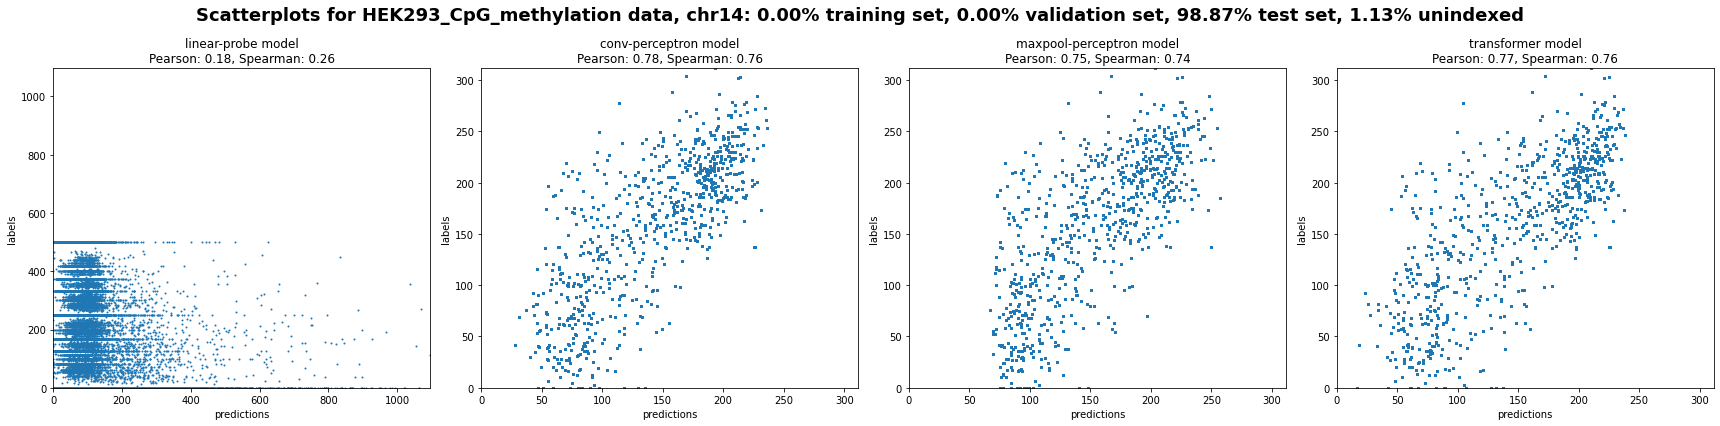

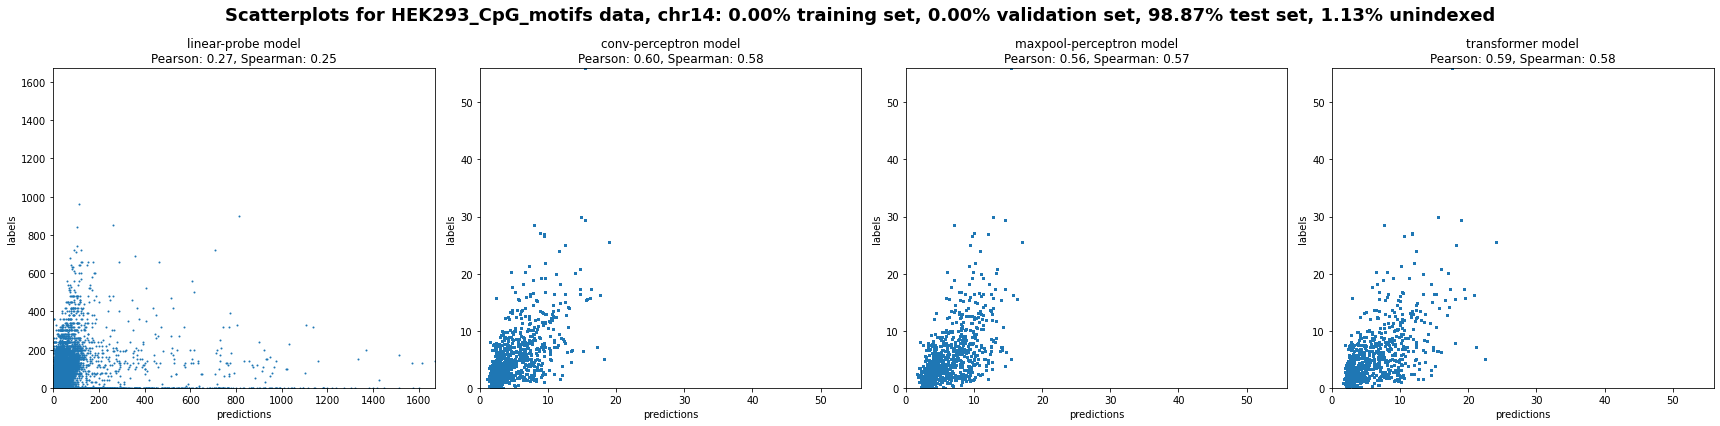

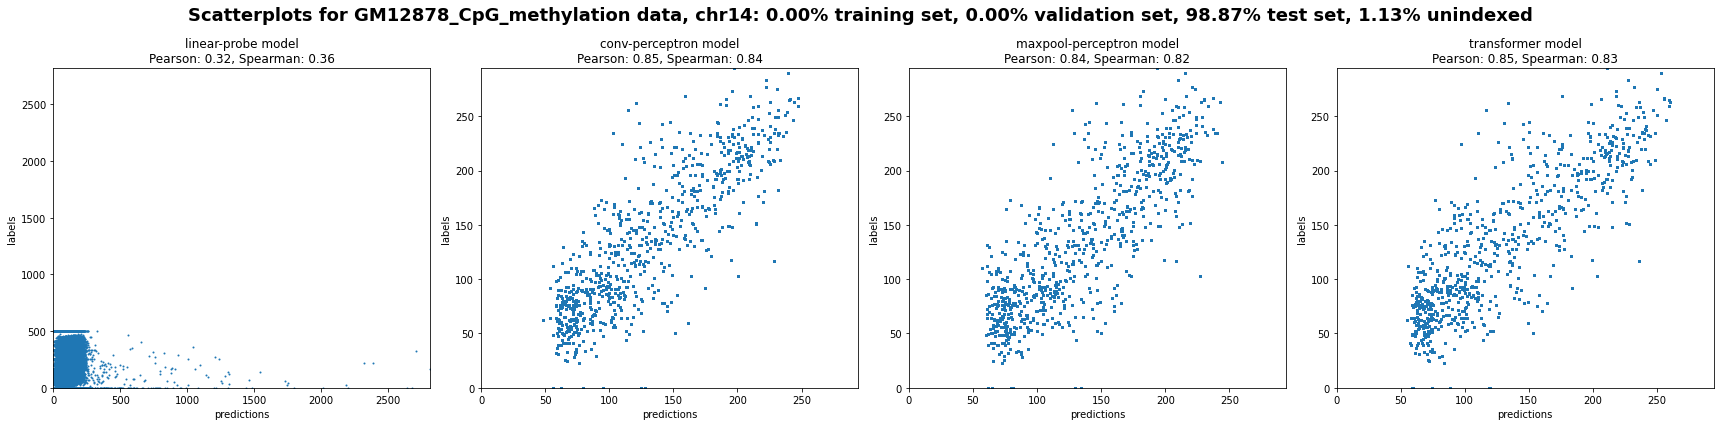

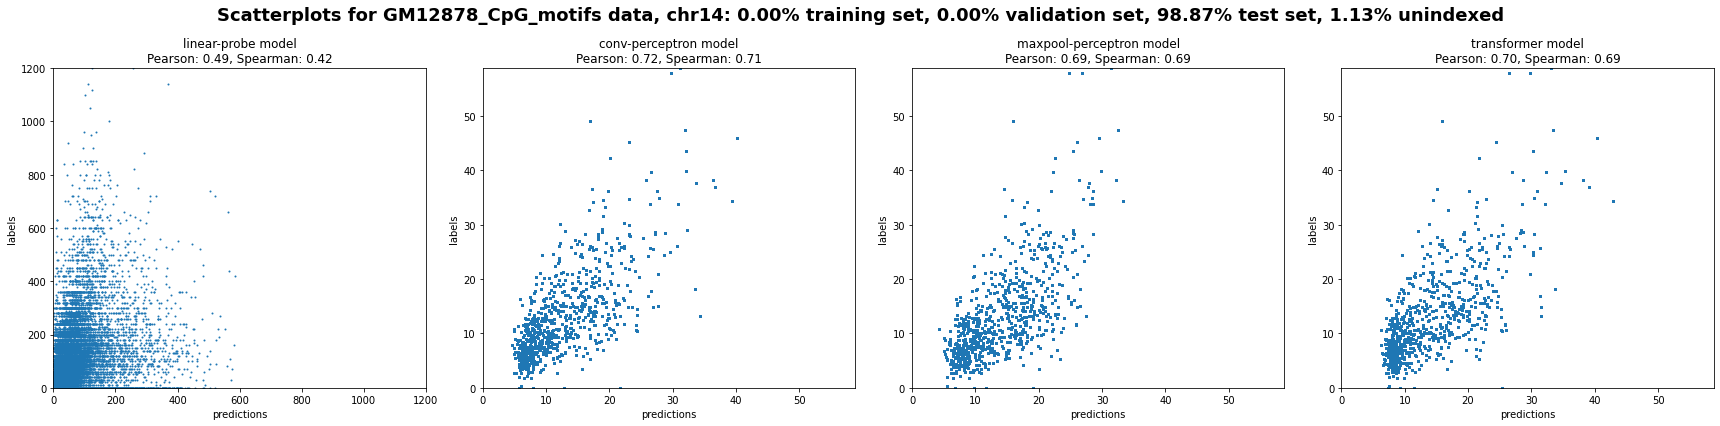

In [11]:
for i,track_name in enumerate(all_tracks):
#     print(track_name)
    fig1, axs1 = plt.subplots(1,4,figsize=(24,6))
    for idx,(key,output_array) in enumerate(output_arrays.items()):
        fig1.suptitle(f'Scatterplots for {track_name} data, {plot_chrom}: {sets_string}',fontweight='bold',size=18)
        if h5_files_dict[key][1]=='128bp_bins':
            pearson, _ = pearsonr(np.nan_to_num(output_array[:,i]),np.nan_to_num(plot_array_high_res[:,i]))
            spearman, _ = spearmanr(np.nan_to_num(output_array[:,i]),np.nan_to_num(plot_array_high_res[:,i]))
            upper_lim = np.maximum(np.max(np.nan_to_num(output_array[:,i])),np.max(np.nan_to_num(plot_array_high_res[:,i])))
            axs1[idx].scatter(output_array[:,i],plot_array_high_res[:,i],s=1)
            axs1[idx].set_xlim([0,upper_lim])
            axs1[idx].set_ylim([0,upper_lim])
            axs1[idx].set_xlabel('predictions')
            axs1[idx].set_ylabel('labels')
            axs1[idx].set_title(f'{key} model\nPearson: {pearson:.2f}, Spearman: {spearman:.2f}')
        elif h5_files_dict[key][1]=='single_bin':
            pearson, _ = pearsonr(np.nan_to_num(output_array[:,i]),np.nan_to_num(plot_array_low_res[:,i]))
            spearman, _ = spearmanr(np.nan_to_num(output_array[:,i]),np.nan_to_num(plot_array_low_res[:,i]))
            upper_lim = np.maximum(np.max(np.nan_to_num(output_array[:,i])),np.max(np.nan_to_num(plot_array_low_res[:,i])))
            axs1[idx].scatter(output_array[:,i],plot_array_low_res[:,i],s=1)
            axs1[idx].set_xlim([0,upper_lim])
            axs1[idx].set_ylim([0,upper_lim])
            axs1[idx].set_xlabel('predictions')
            axs1[idx].set_ylabel('labels')
            axs1[idx].set_title(f'{key} model\nPearson: {pearson:.2f}, Spearman: {spearman:.2f}')
        print(f'{track_name}\t{key}\tpearson: {pearson}\tspearman: {spearman}')
            
    plt.tight_layout()
plt.show()


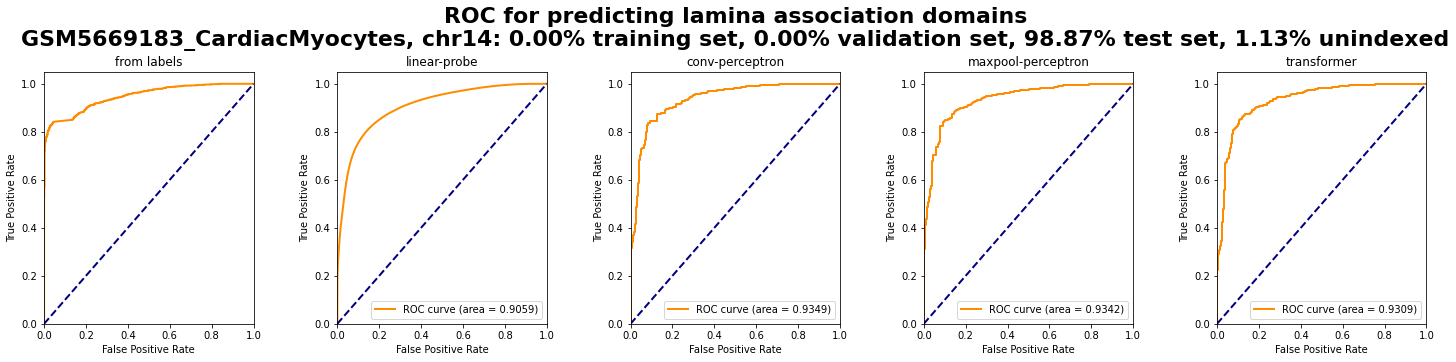

In [12]:
dataset_mask = test_train_split_array==3
fig1, axs1 = plt.subplots(1,5,figsize=(24,5))
fig1.suptitle(f'ROC for predicting lamina association domains\n{all_tracks[0]}, {plot_chrom}: {sets_string}',fontweight='bold',size=22)
fpr, tpr, thresholds = roc_curve(lads_array[dataset_mask]>0,np.nan_to_num(plot_array_high_res[dataset_mask,0]))
roc_auc = auc(fpr, tpr)
axs1[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
axs1[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs1[0].set_xlim([0.0, 1.0])
axs1[0].set_ylim([0.0, 1.05])
axs1[0].set_xlabel('False Positive Rate')
axs1[0].set_ylabel('True Positive Rate')
axs1[0].set_title(f'from labels')
for indx,(key,output_array) in enumerate(output_arrays.items()):
    fpr, tpr, thresholds = roc_curve(lads_array[dataset_mask]>0,np.nan_to_num(output_array[dataset_mask,0]))
    roc_auc = auc(fpr, tpr)
    
    axs1[indx+1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    axs1[indx+1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs1[indx+1].set_xlim([0.0, 1.0])
    axs1[indx+1].set_ylim([0.0, 1.05])
    axs1[indx+1].set_xlabel('False Positive Rate')
    axs1[indx+1].set_ylabel('True Positive Rate')
    axs1[indx+1].set_title(f'{key}')
    axs1[indx+1].legend(loc="lower right")
fig1.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1, hspace=0.5, wspace=0.4)
plt.show()

In [13]:
# tss_dict = defaultdict(list)
# for f in tqdm(gtf):
#     if f[2]=='gene':
#         if f[6]=='+':
#             tss_dict[f[0]].append((f[8],int(f[3])))
#         elif f[6]=='-':
#             tss_dict[f[0]].append((f[8],int(f[4])))

In [14]:
# hek_tss_cpgs_list = []
# gm_tss_cpgs_list = []
# hek_pred_tss_cpgs_list = []
# gm_pred_tss_cpgs_list = []
# tss_cpgs_window = 2048
# hek_dataset_channel = 14
# gm_dataset_channel = 16
# for gene_obj in tss_dict[plot_chrom]:
#     tss = gene_obj[1]
#     hek_tss_cpgs_list.append(np.mean(np.nan_to_num(plot_array_high_res[(tss-tss_cpgs_window)//128:(tss+tss_cpgs_window)//128,hek_dataset_channel]))/500)
#     gm_tss_cpgs_list.append(np.mean(np.nan_to_num(plot_array_high_res[(tss-tss_cpgs_window)//128:(tss+tss_cpgs_window)//128,gm_dataset_channel]))/500)
#     hek_pred_tss_cpgs_list.append(np.mean(np.nan_to_num(plot_array_pred_high_res[(tss-tss_cpgs_window)//128:(tss+tss_cpgs_window)//128,hek_dataset_channel]))/500)
#     gm_pred_tss_cpgs_list.append(np.mean(np.nan_to_num(plot_array_pred_high_res[(tss-tss_cpgs_window)//128:(tss+tss_cpgs_window)//128,gm_dataset_channel]))/500)

In [15]:
# delta_thresh = 0.2
# mask = ~((1-delta_thresh)<np.array(hek_tss_cpgs_list)/(np.array(gm_tss_cpgs_list)+1e-9)) | ~((1/(1-delta_thresh))>np.array(hek_tss_cpgs_list)/(np.array(gm_tss_cpgs_list)+1e-9))
# plt.scatter(np.array(hek_tss_cpgs_list)[mask],np.array(gm_tss_cpgs_list)[mask])
# # plt.xscale('log')
# # plt.yscale('log')

In [16]:
# plt.scatter(np.array(hek_pred_tss_cpgs_list)[mask],np.array(gm_pred_tss_cpgs_list)[mask])

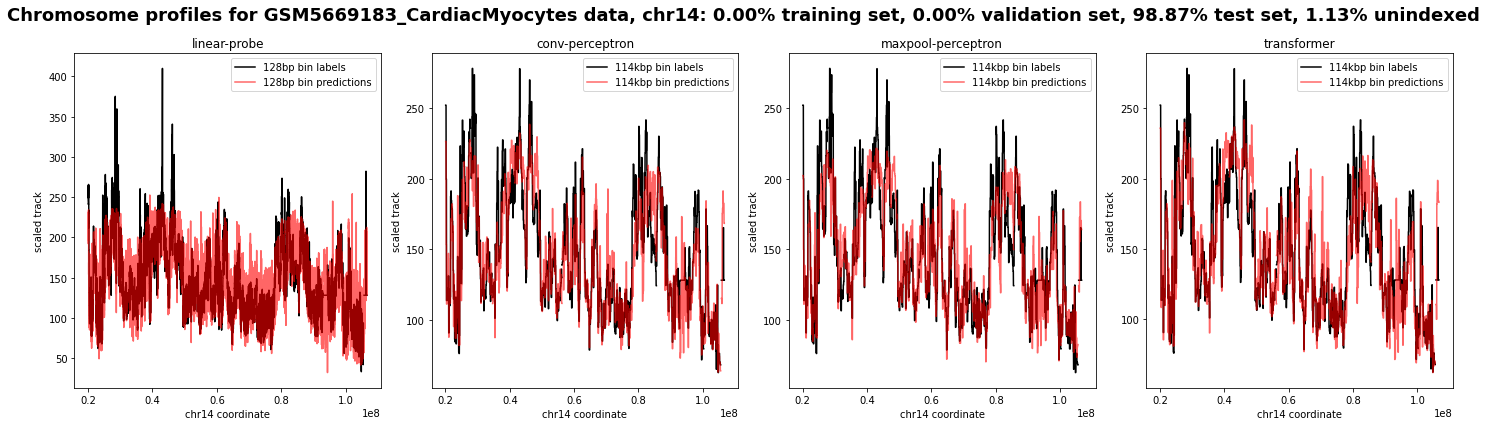

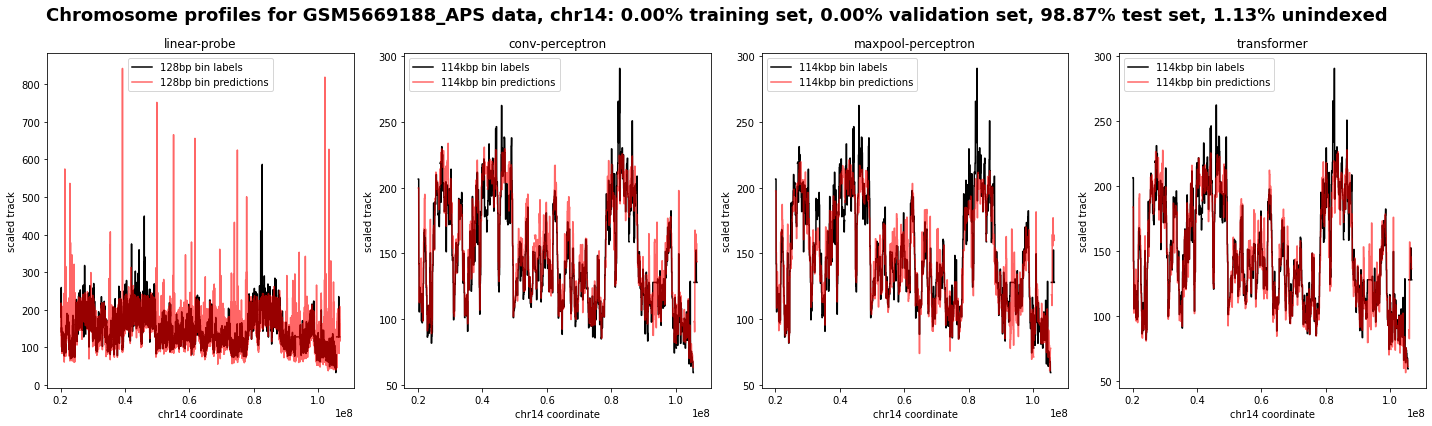

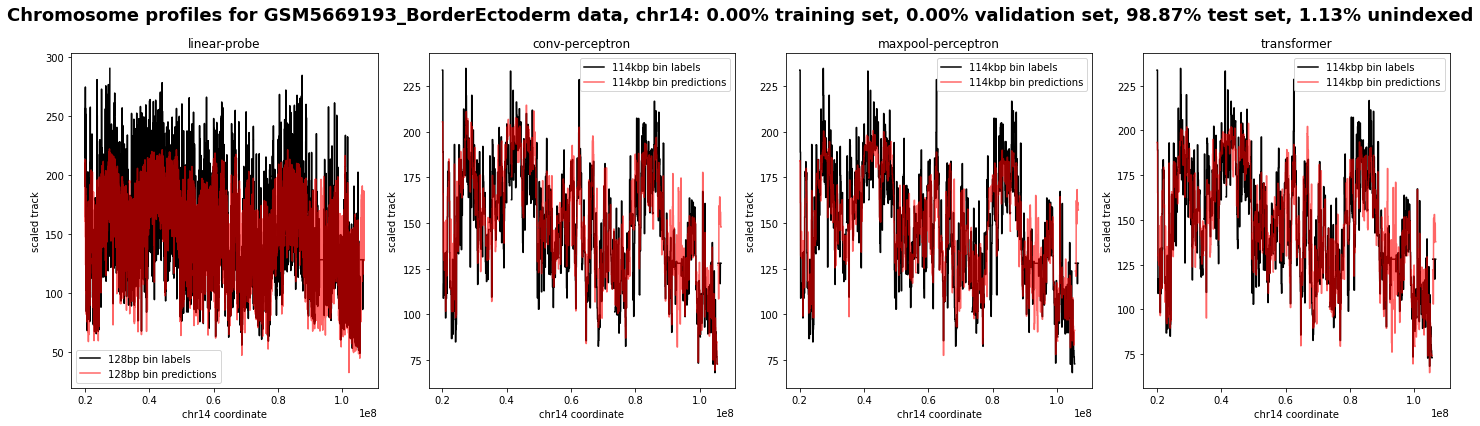

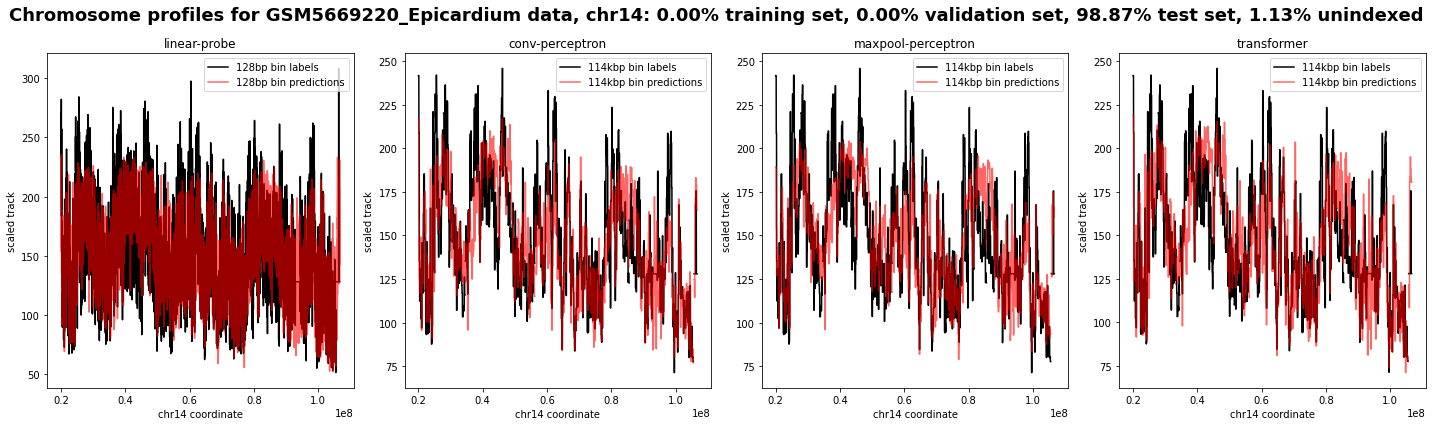

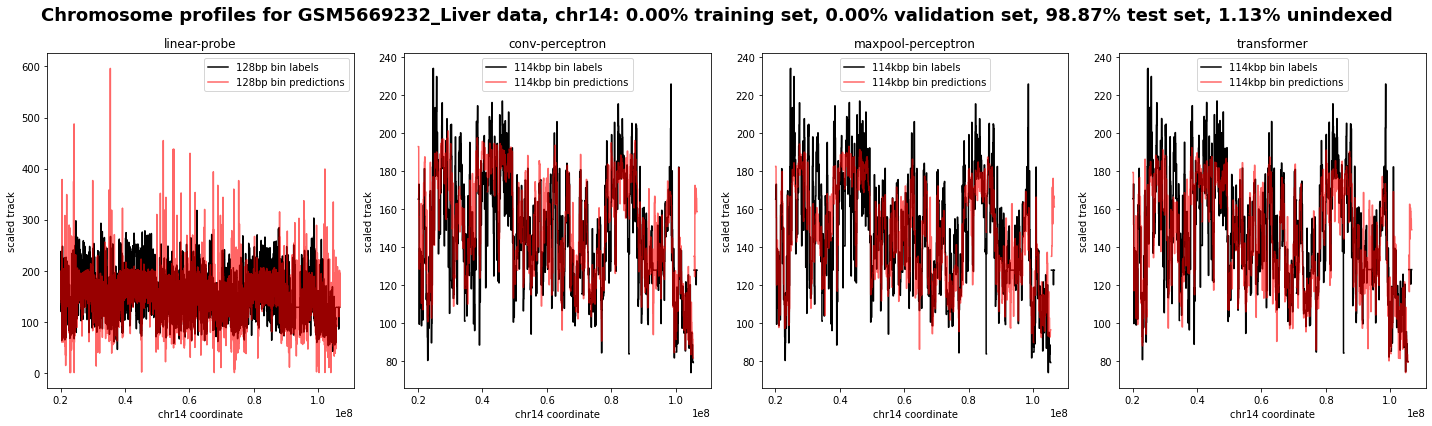

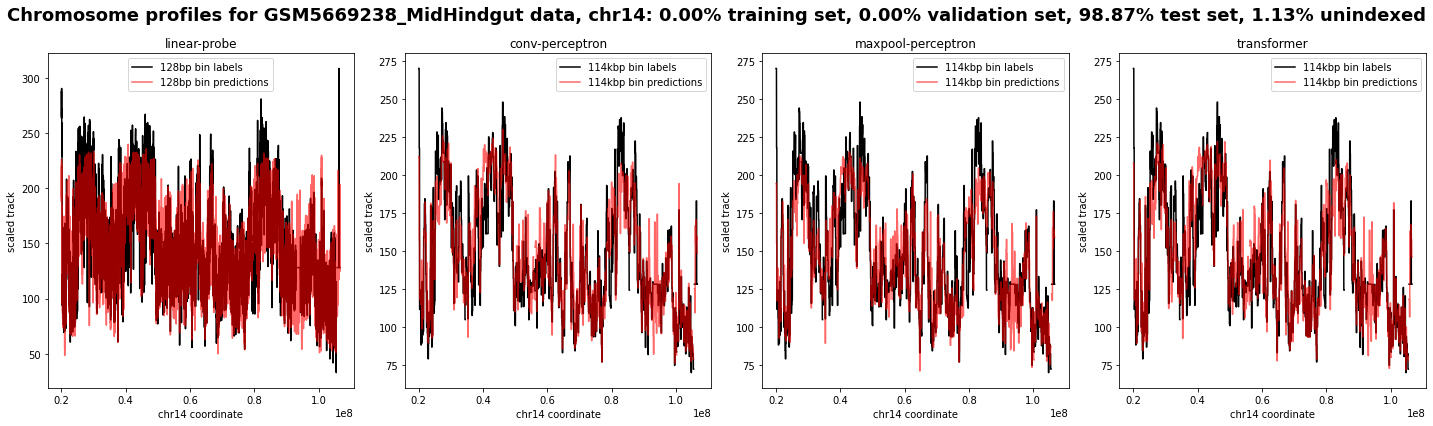

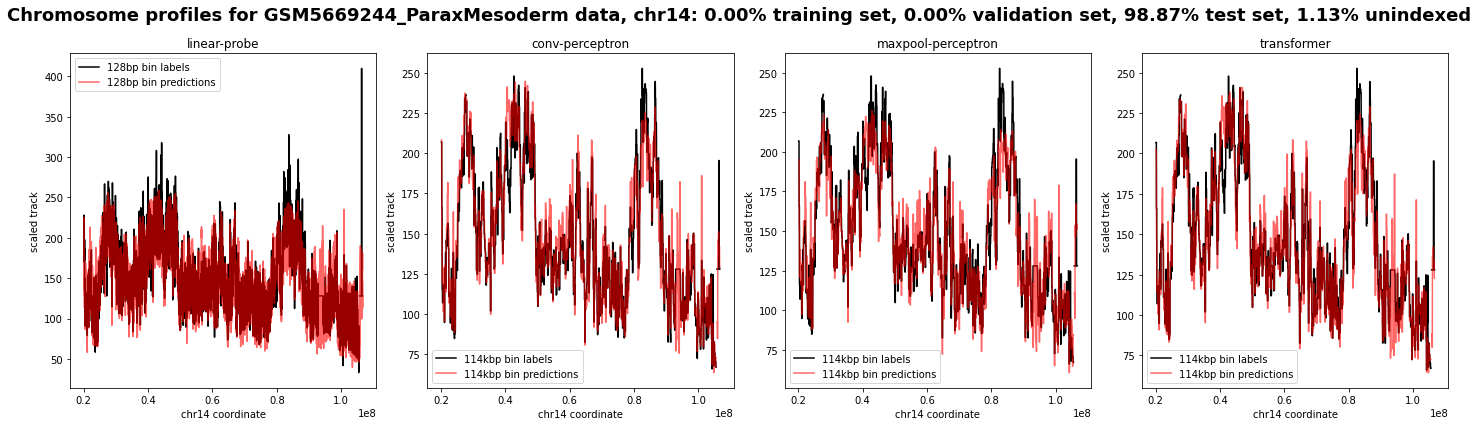

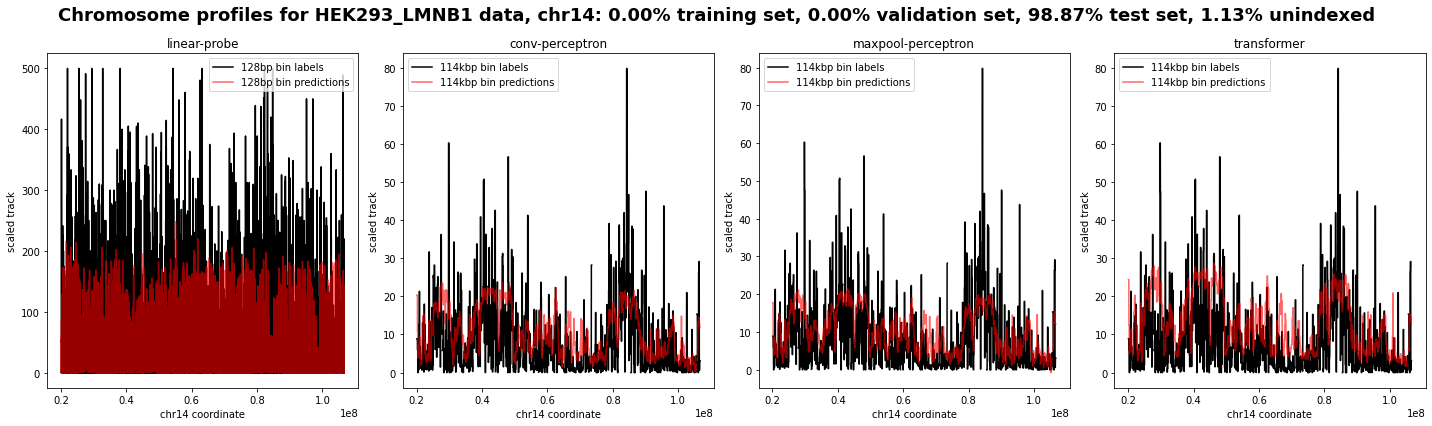

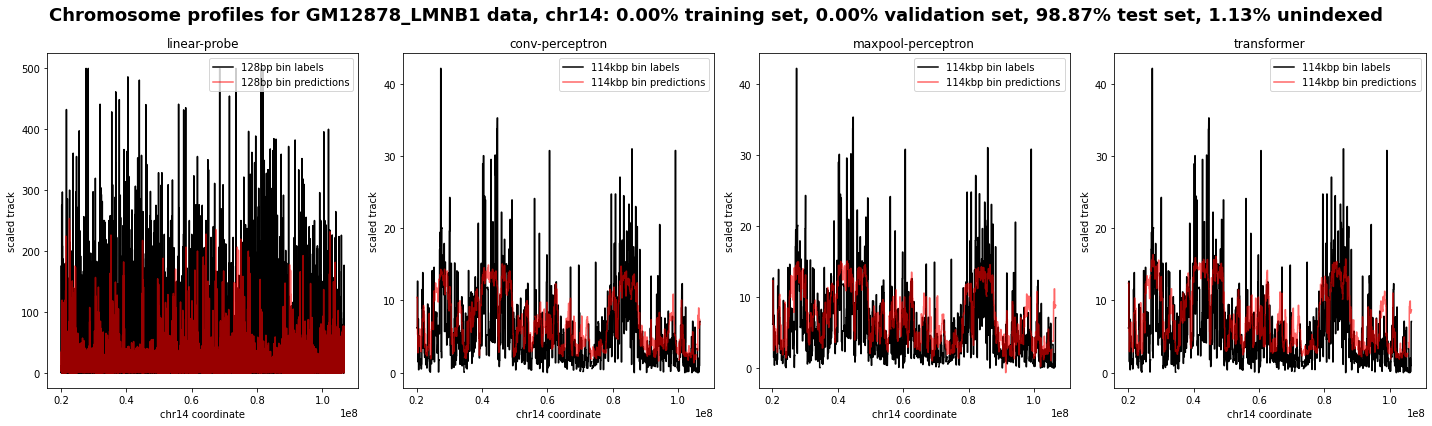

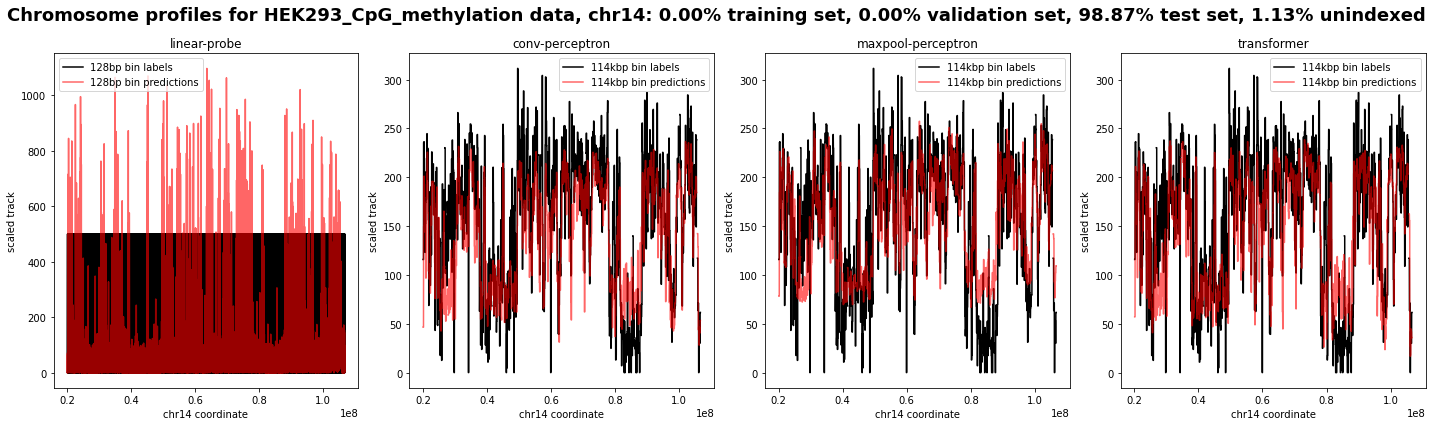

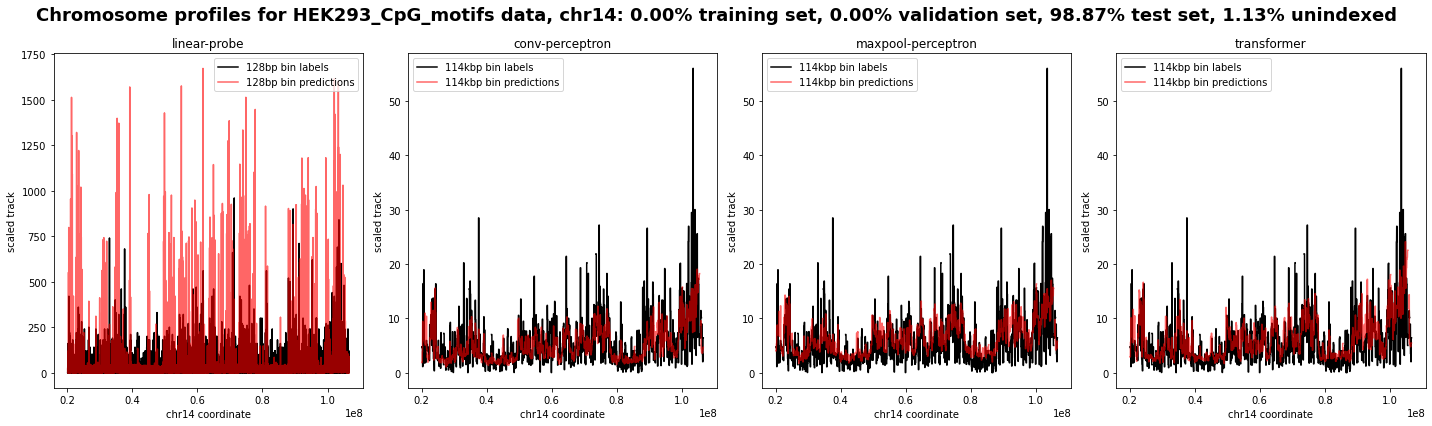

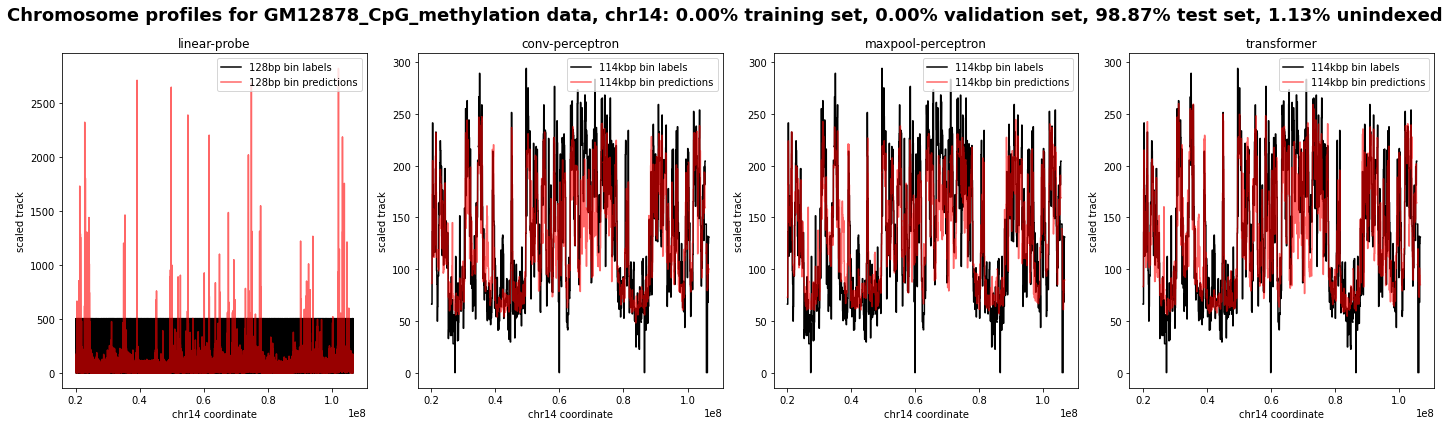

In [17]:
colors = {0: '1.0', 1: '0.9', 2: '0.75', 3: '0.5'}
def apply_fill_between(ax, x_coords, y_data, split_array, colors):
    start_idx = 0
    for i in range(1, len(split_array)):
        if split_array[i] != split_array[start_idx]:
            ax.fill_between(x=x_coords[start_idx:i], y1=y_data[start_idx:i], color=colors[split_array[start_idx]])
            start_idx = i
    
    ax.fill_between(x_coords[start_idx:], y_data[start_idx:], color=colors[split_array[start_idx]])


# fig2, axs2 = plt.subplots(6,3,figsize=(12,22))
for i,track_name in enumerate(all_tracks):
#     print(track_name)
    fig1, axs1 = plt.subplots(1,4,figsize=(20,6))
    fig1.suptitle(f'Chromosome profiles for {track_name} data, {plot_chrom}: {sets_string}',fontweight='bold',size=18)
    for idx,(key,output_array) in enumerate(output_arrays.items()):
#         apply_fill_between(axs1[row,col],plot_xcoord,
#                            np.max(np.nan_to_num(plot_array_high_res[:, i]))*np.ones(len(plot_array_high_res[:, i])),
#                            test_train_split_array, colors)
        if h5_files_dict[key][1]=='128bp_bins':
            axs1[idx].plot(plot_xcoord,plot_array_high_res[:,i],'k',label='128bp bin labels')  
            axs1[idx].plot(plot_xcoord,output_array[:,i],'r-',alpha=0.6,label='128bp bin predictions')
        elif h5_files_dict[key][1]=='single_bin':
            axs1[idx].plot(plot_xcoord,plot_array_low_res[:,i],'k',label='114kbp bin labels')
            axs1[idx].plot(plot_xcoord,output_array[:,i],'r-',alpha=0.6,label='114kbp bin predictions')
        axs1[idx].set_title(f'{key}')
#         axs1[row,col].set_yscale('log')
#         axs1[row,col].set_ylim([1,600])
    #     axs1[row,col].plot(plot_xcoord,plot_array_pred_high_res[:,i],'r-',alpha=0.6,label='114kbp bin')

#         axs1[row,col].set_title(all_tracks[i])
        axs1[idx].set_ylabel('scaled track')
        axs1[idx].set_xlabel(f'{plot_chrom} coordinate')
#         light_gray_patch = mpatches.Patch(color='0.9', label='train regions')
#         medium_gray_patch = mpatches.Patch(color='0.75', label='validation regions')
#         dark_gray_patch = mpatches.Patch(color='0.5', label='test regions')
        axs1[idx].legend()
#         handles,labels = axs1[row,col].get_legend_handles_labels()
#         handles.extend([light_gray_patch, medium_gray_patch, dark_gray_patch])
#         labels.extend(['train regions','validation regions','test regions'])
#         axs1[row,col].legend(handles=handles,labels=labels)
    plt.tight_layout()
    plt.show()
    
#     ax2 = axs1[row,col].twinx()
#     ax2.plot(plot_xcoord,lads_array,'k.',alpha=0.3)
#     ax2.set_ylabel('HMM lad')